# DSC 511: Project
# Part 2: EDA
# Argentina houses' price prediction

In [1]:
! pip install pyspark seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=ccca15ecb4ef61940da66dc5494a8ea88013b5138e41d1958a0f1a600078db84
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
# libraries

import sklearn
from sklearn.impute import KNNImputer
import pandas as pd
from pyspark.sql.functions import *
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.functions import regexp_replace, split
from pyspark.sql import functions as F
from pyspark.sql.types import DateType

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
google_drive_path = "/content/gdrive/MyDrive/Colab Notebooks/Project/"

Mounted at /content/gdrive


In [4]:
# this is our schema defined in order for spark to read the csv correctly IMPUTED
spark = SparkSession.builder.appName("Project511_EDA").master("local[*]").getOrCreate()

Read the dataset:

In [10]:
# Load the Parquet file
result_df = spark.read.format("parquet").load(google_drive_path + "ar_properties_processed.parquet")

In [11]:
result_df.show()

+----------+----------+--------------------+-------+-----+--------+---------+-------------+---------------+--------------------+--------------------+-------------+--------------+--------------------+-----------------+
|start_date|  end_date|                  l2|     l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|               title|         description|property_type|operation_type|         coordinates|   amount_in_euro|
+----------+----------+--------------------+-------+-----+--------+---------+-------------+---------------+--------------------+--------------------+-------------+--------------+--------------------+-----------------+
|2020-11-02|2020-11-16|Bs.As. G.B.A. Zon...|  Tigre|    2|       2|        1|        550.0|          267.0|Venta lote Las Ti...|Lote interno en z...|          Lot|          Sale|[-34.406894683837...|         154700.0|
|2020-11-02|9999-12-31|            Santa Fe| Alvear|    2|       2|        1|       438.17|         347.07|Vendo lote de 268...|

In [12]:
# casting amount to euro to integer (round down)
result_df = result_df.withColumn("amount_in_euro", round("amount_in_euro", 0).cast("integer"))

In [13]:
result_df.show()

+----------+----------+--------------------+-------+-----+--------+---------+-------------+---------------+--------------------+--------------------+-------------+--------------+--------------------+--------------+
|start_date|  end_date|                  l2|     l3|rooms|bedrooms|bathrooms|surface_total|surface_covered|               title|         description|property_type|operation_type|         coordinates|amount_in_euro|
+----------+----------+--------------------+-------+-----+--------+---------+-------------+---------------+--------------------+--------------------+-------------+--------------+--------------------+--------------+
|2020-11-02|2020-11-16|Bs.As. G.B.A. Zon...|  Tigre|    2|       2|        1|        550.0|          267.0|Venta lote Las Ti...|Lote interno en z...|          Lot|          Sale|[-34.406894683837...|        154700|
|2020-11-02|9999-12-31|            Santa Fe| Alvear|    2|       2|        1|       438.17|         347.07|Vendo lote de 268...|<b>Vendo lot

In [14]:
result_df.count() #number of rows

259910

### Convert to Pandas for visualisation

In [15]:
df_filled=result_df.toPandas()

In [16]:
df_filled.shape

(259910, 15)

In [17]:
df_filled.head()

,start_date,end_date,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,title,description,property_type,operation_type,coordinates,amount_in_euro
0,2020-11-02,2020-11-16,Bs.As. G.B.A. Zona Norte,Tigre,2,2,1,550.00,267.00,Venta lote Las Tipas Nordelta,Lote interno en zona central en el barrio Las ...,Lot,Sale,"[-34.40689468383789, -58.676631927490234]",154700
1,2020-11-02,9999-12-31,Santa Fe,Alvear,2,2,1,438.17,347.07,Vendo lote de 268 m2 en Ecopueblo sobre avenid...,<b>Vendo lote de 268 m2 en Ecopueblo sobre ave...,Lot,Sale,"[-33.054500579833984, -60.60318374633789]",24115
2,2020-11-02,9999-12-31,Santa Fe,Alvear,2,2,1,438.17,347.07,Terreno en oportunidad en Ecopueblo sobre aven...,<b>Terreno en oportunidad en Ecopueblo sobre a...,Lot,Sale,"[-33.054500579833984, -60.60318374633789]",24115
3,2020-11-02,9999-12-31,Santa Fe,Alvear,2,2,1,438.17,347.07,Barrio abierto Ecopueblo. Desde 250 m2 con ent...,<b>Barrio abierto Ecopueblo. Desde 250 m2 con ...,Lot,Sale,"[-33.054500579833984, -60.60318374633789]",18200
4,2020-11-02,2021-01-22,Buenos Aires Interior,Luján,2,2,1,438.17,347.07,"Terreno Lote en Venta ubicado en Los Juncos, ...",Lotes en Venta\n\nUbicación: Barrio Cerrado Lo...,Lot,Sale,"[-34.54405212402344, -59.130374908447266]",21021


## Correlation Matrix


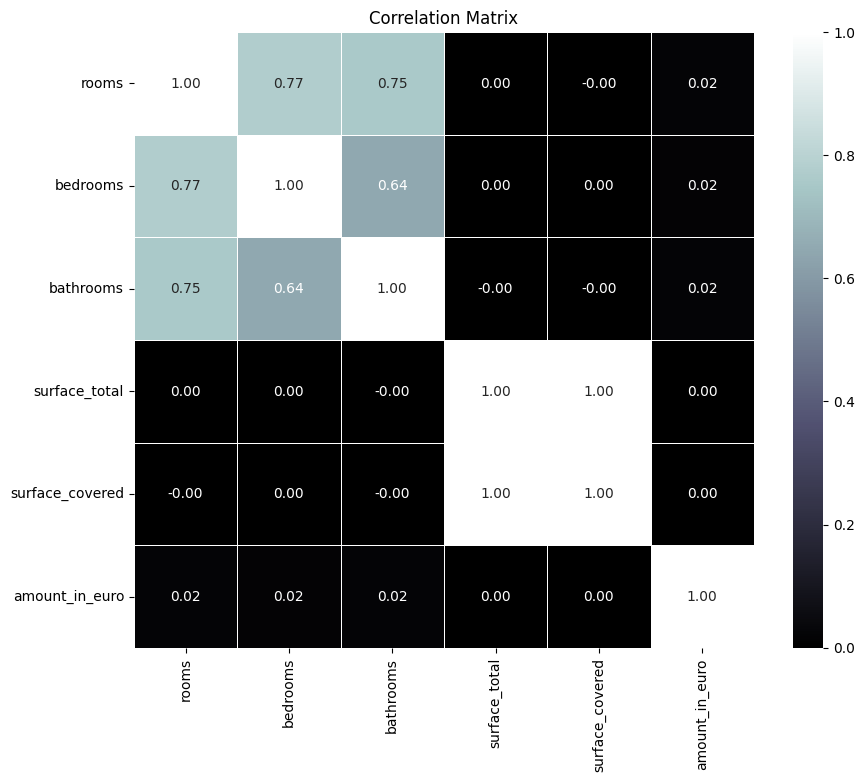

In [26]:
## Correlation Matrix

# Filter numeric columns
numeric = df_filled.select_dtypes(include=['float32','float64', 'int64','int32']).columns

# Create an empty correlation matrix dictionary
correlation_matrix = {}

# Compute correlations
for col1 in numeric:
    correlation_matrix[col1] = {}
    for col2 in numeric:
        correlation_matrix[col1][col2] = df_filled[col1].corr(df_filled[col2])

# Convert correlation matrix to DataFrame
correlation_matrix_df = pd.DataFrame(correlation_matrix)

# Plot the heatmap with the correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_df, annot=True, cmap='bone', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

There aren't any highly correlated variables in the dataset. Specifically, the only notable correlation is a value of 0.77 between the number of bedrooms and the total number of rooms, as well as a positive correlation of 0.75 between the number of bathrooms and the total number of rooms. Additionally, there's another pair of correlated variables: the number of bedrooms and the number of bathrooms, with a smaller correlation of 0.64.

Initially, we noticed a high correlation between surface_total and surface_covered, indicating that they contain nearly identical information. However, we decided to retain both features in our dataset because they seemed to give us useful info separately. Our data preprocessing and testing revealed that each variable independently contributed valuable information to our model. The reason we ended up with a high correlation between "surface_total" and "surface_covered" is because we used a special method called KNN-based imputation to fill in missing values. This method made sure that when we guessed values for "surface_total", they were always bigger or the same as the ones we guessed for "surface_covered". This makes sense because the total area of a property should always be at least as big as the area covered by buildings. So, because of this process, the two columns ended up being very similar.

Later on, as we worked more on our recommendation system and machine learning, we realized having both was a bit much. So, we dropped one to make things simpler and work better. This helped our system run smoother and understand the data more clearly.

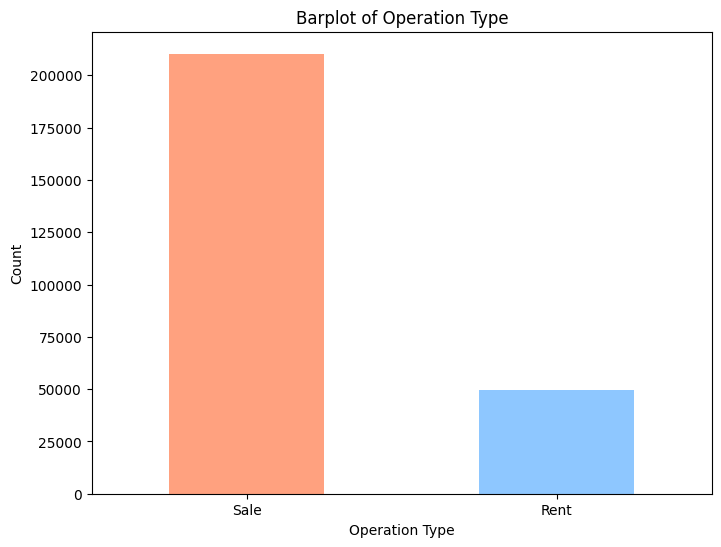

In [27]:
## Target Variable : Operation Type

# Count the frequency of each operation type
operation_types = ['Sale', 'Rent']
operation_type_counts = df_filled['operation_type'].value_counts()

# Create a bar plot
colors = ['orangered', 'dodgerblue']
operation_type_counts.plot(kind='bar', rot=0, figsize=(8, 6), color = colors, alpha = .5)
plt.title('Barplot of Operation Type')
plt.xlabel('Operation Type')
plt.ylabel('Count')
plt.xticks(range(len(operation_types)), operation_types)
plt.show()

In [ ]:
# Imbalanced dataset
df_filled['operation_type'].value_counts()

operation_type
Sale    210341
Rent     49569
Name: count, dtype: int64

The 'Sale' category has 5 times more instances than the 'Rent' category.

In [ ]:
df_filled_date=df_filled

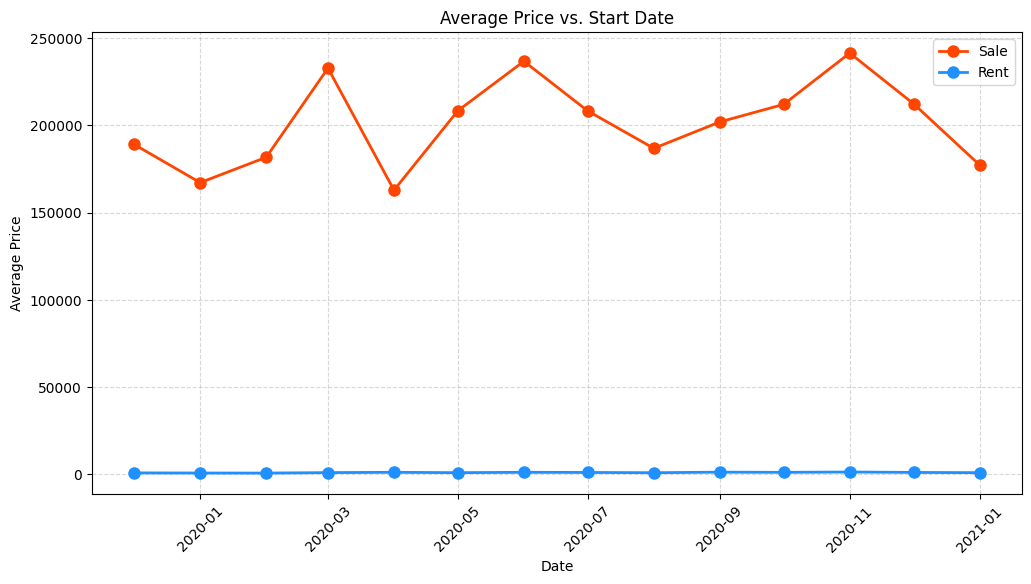

In [ ]:
# average price for each month for both operation types based on the start_date
df_filled_date = df_filled.copy()
df_filled_date['start_date'] = pd.to_datetime(df_filled_date['start_date'])

df_buy = df_filled_date[df_filled_date['operation_type'] == 'Sale']
df_rent = df_filled_date[df_filled_date['operation_type'] == 'Rent']

average_prices_buy = df_buy.groupby(df_buy['start_date'].dt.to_period('M'))['amount_in_euro'].mean()
average_prices_rent = df_rent.groupby(df_rent['start_date'].dt.to_period('M'))['amount_in_euro'].mean()

# Line plots create the line plots
plt.figure(figsize=(12, 6))
plt.plot(average_prices_buy.index.to_timestamp(), average_prices_buy.values, label='Sale', marker='o', linestyle='-', color='orangered', linewidth=2, markersize=8)
plt.plot(average_prices_rent.index.to_timestamp(), average_prices_rent.values, label='Rent', marker='o', linestyle='-', color='dodgerblue', linewidth=2, markersize=8)
plt.title('Average Price vs. Start Date')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

The line graph illustrates the average prices for sales and rentals over a period from January 2020 to January 2021. The sales prices, shown in red, exhibit significant fluctuation throughout the year, peaking at around 250,000 in March and November 2020, and showing a notable decline towards January 2021. On the other hand, rental prices, represented by the blue line, remain constant throughout the year, consistently near the baseline, indicating no significant change over time. This stability in rental prices contrasts sharply with the volatility observed in sales prices, highlighting different market dynamics or economic factors affecting sales versus rentals during this period.


To see closer the results we decided to separet the two categories.

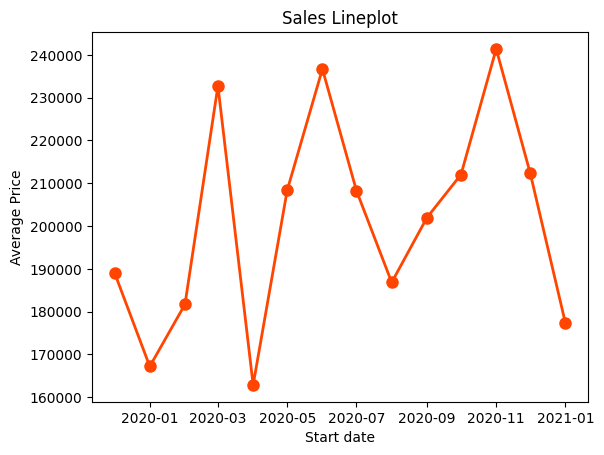

In [ ]:
plt.plot(average_prices_buy.index.to_timestamp(), average_prices_buy.values, marker='o', linestyle='-', color='orangered', linewidth=2, markersize=8)
plt.title('Sales Lineplot')
plt.xlabel('Start date')
plt.ylabel('Average Price')
plt.show()

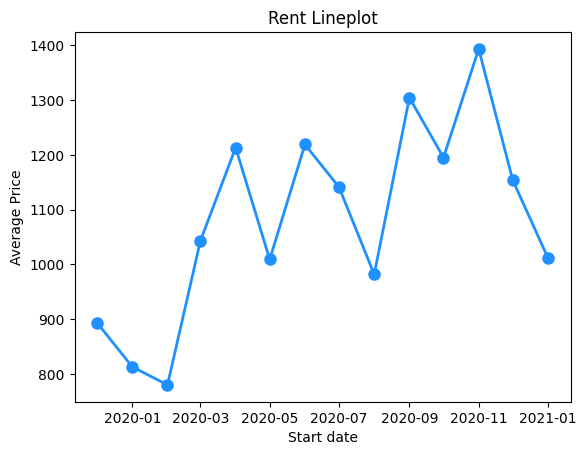

In [ ]:
plt.plot(average_prices_rent.index.to_timestamp(), average_prices_rent.values, marker='o', linestyle='-', color='dodgerblue', linewidth=2, markersize=8)
plt.title('Rent Lineplot')
plt.xlabel('Start date')
plt.ylabel('Average Price')
plt.show()

<u>Comments:</u>  
1) The sales prices are consistently higher than rent prices, which is expected as purchasing property typically requires a larger upfront investment compared to renting.  
2) Notably, around March 2020, there’s a dip in the average sales prices, followed by a peak in April 2020. This might align with initial pandemic shocks and subsequent policy responses, such as interest rate cuts or government interventions.  
3) Rent prices also show an increase during this period, which might be due to increased demand for rentals as people opted for more flexible housing arrangements during uncertain times.


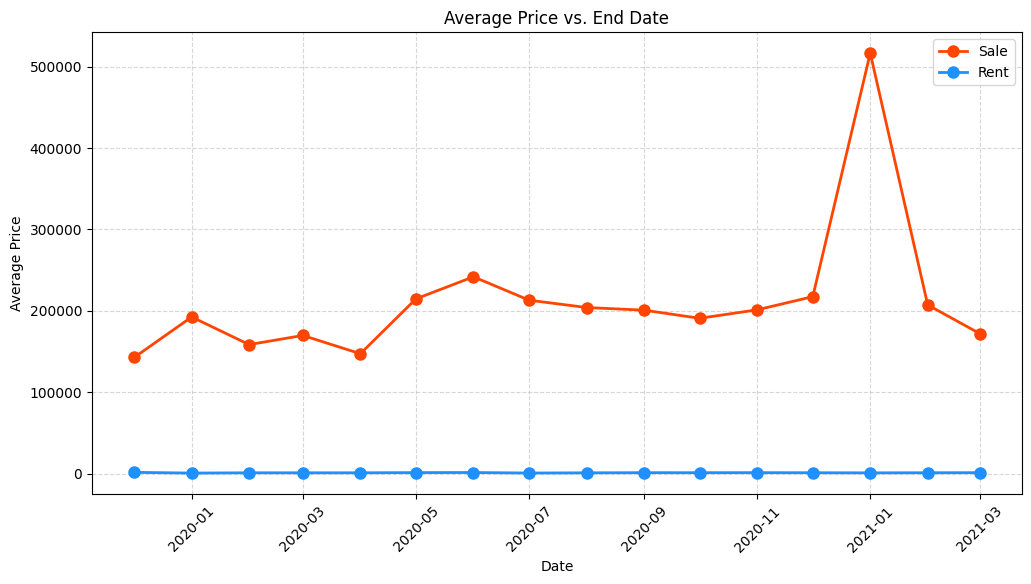

In [ ]:
# average price for each month for both operation types based on the end_date
df_filled_date = df_filled.copy()
df_filled_date['end_date'] = pd.to_datetime(df_filled_date['end_date'], errors='coerce')

df_filled_date.dropna(subset=['end_date'], inplace=True)

df_buy = df_filled_date[df_filled_date['operation_type'] == 'Sale']
df_rent = df_filled_date[df_filled_date['operation_type'] == 'Rent']

average_prices_buy = df_buy.groupby(df_buy['end_date'].dt.to_period('M'))['amount_in_euro'].mean()
average_prices_rent = df_rent.groupby(df_rent['end_date'].dt.to_period('M'))['amount_in_euro'].mean()

# Line plots
plt.figure(figsize=(12, 6))
plt.plot(average_prices_buy.index.to_timestamp(), average_prices_buy.values, label='Sale', marker='o', linestyle='-', color='orangered', linewidth=2, markersize=8 )
plt.plot(average_prices_rent.index.to_timestamp(), average_prices_rent.values, label='Rent', marker='o', linestyle='-', color='dodgerblue', linewidth=2, markersize=8)
plt.title('Average Price vs. End Date')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

Text(0, 0.5, 'Average Price')

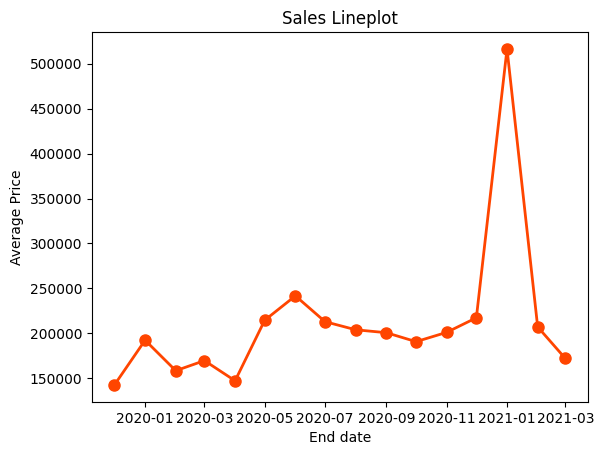

In [ ]:
plt.plot(average_prices_buy.index.to_timestamp(), average_prices_buy.values, marker='o', linestyle='-', color='orangered', linewidth=2, markersize=8 )
plt.title('Sales Lineplot')
plt.xlabel('End date')
plt.ylabel('Average Price')

Text(0, 0.5, 'Average Price')

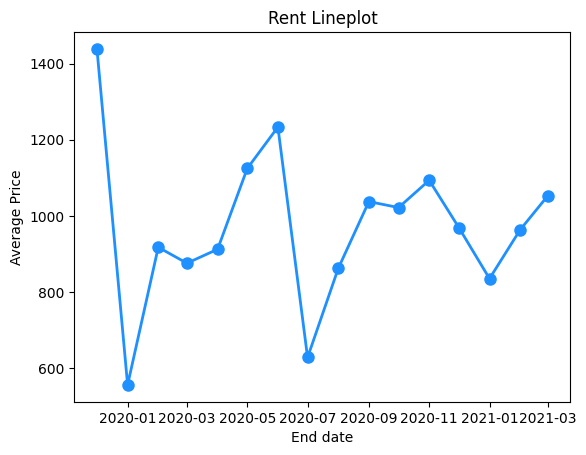

In [ ]:
plt.plot(average_prices_rent.index.to_timestamp(), average_prices_rent.values, marker='o', linestyle='-', color='dodgerblue', linewidth=2, markersize=8)
plt.title('Rent Lineplot')
plt.xlabel('End date')
plt.ylabel('Average Price')

<u>Comments:</u>  
1) **Rent Lineplot**: The rent line plot begins with a sharp peak around January 2020, reaching over 1400 for average rent prices. This spike might be due to unusual market conditions or a specific high-value rental transaction.
After the initial spike, the rent prices fluctuate around a more stable range, typically between 600 and 1200. This indicates that the initial spike was likely an outlier, and the market has since settled.  
2) **Sales Lineplot**:The sales line plot starts with a gradual increase, peaking sharply around early 2021. This spike to over 500,000 indicates a notable high-value sale or a market anomaly. Following the peak, the sales prices drop sharply, returning to levels consistent with the earlier trend. This suggests that the spike was not sustainable or representative of broader market trends.

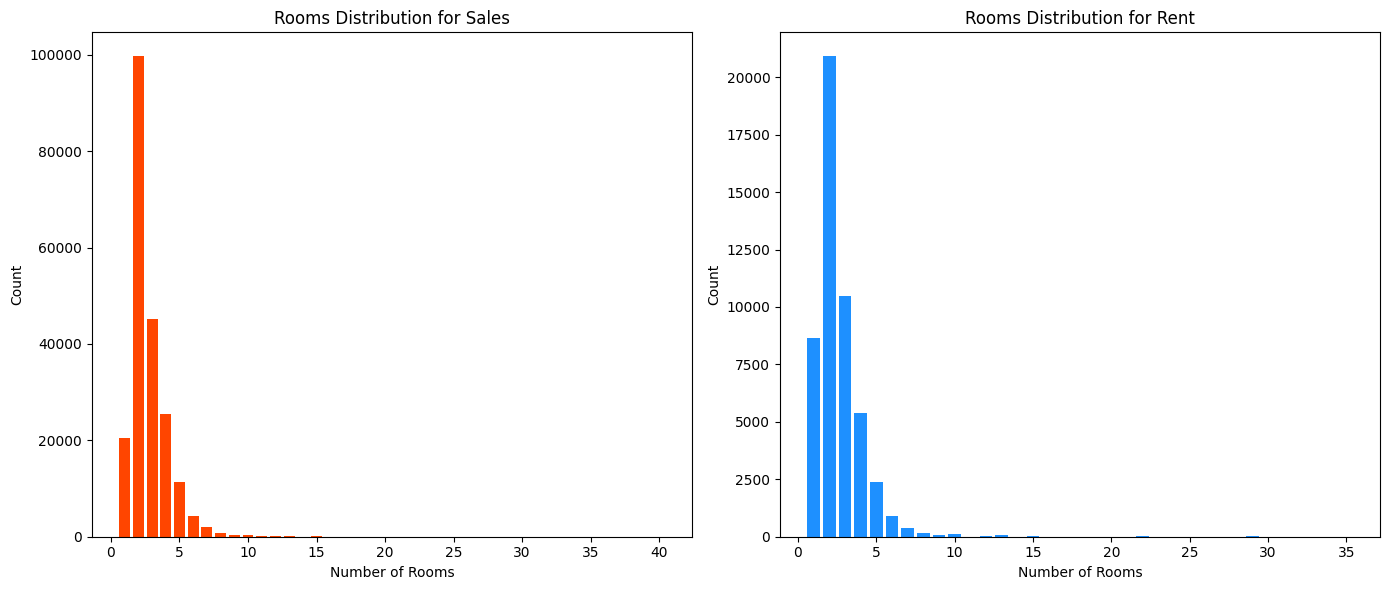

In [ ]:
# Sales/Rent Room Distribution
df_buy = df_filled[df_filled['operation_type'] == 'Sale']
df_rent = df_filled[df_filled['operation_type'] == 'Rent']

value_counts_buy = df_buy['rooms'].value_counts()
value_counts_rent = df_rent['rooms'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Sales
axes[0].bar(value_counts_buy.index, value_counts_buy.values, color='orangered')
axes[0].set_title('Rooms Distribution for Sales')
axes[0].set_xlabel('Number of Rooms')
axes[0].set_ylabel('Count')

# Rent
axes[1].bar(value_counts_rent.index, value_counts_rent.values, color='dodgerblue')
axes[1].set_title('Rooms Distribution for Rent')
axes[1].set_xlabel('Number of Rooms')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

<u>Comments:</u>  
1)  The preference for smaller properties, both for sale and rent, suggests a market catering to individuals, smaller families, or couples. This trend could be driven by economic conditions, urbanization, or changing family structures in Argentina.  
2) The rental prices show volatility, with significant peaks and valleys. This might indicate sensitivity to changing economic conditions, tenant preferences, or local factors.  
3) The rent line plot starts with a notable spike, which might indicate an unusual market event or an outlier transaction. This should be investigated further to understand its impact on the market.

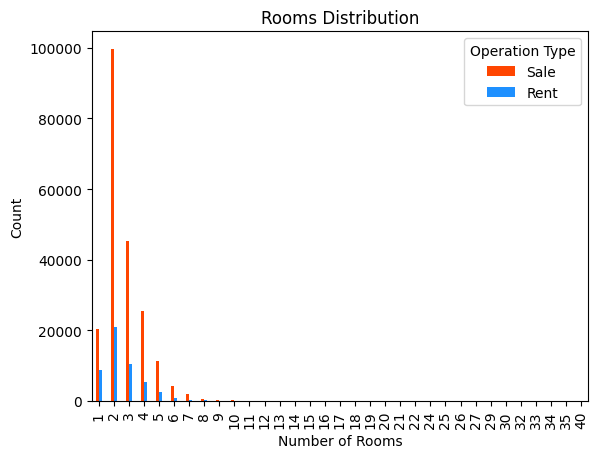

In [ ]:
# Combined plot
value_counts_buy = df_filled[df_filled['operation_type'] == 'Sale']['rooms'].value_counts()
value_counts_rent = df_filled[df_filled['operation_type'] == 'Rent']['rooms'].value_counts()

combined_value_counts = pd.concat([value_counts_buy, value_counts_rent], axis=1)
combined_value_counts.columns = ['Sale', 'Rent']

combined_value_counts.fillna(0, inplace=True)

combined_value_counts.sort_index(inplace=True)

ax = combined_value_counts.plot(kind='bar', width=0.4, color=['orangered', 'dodgerblue'])
ax.set_title('Rooms Distribution')
ax.set_xlabel('Number of Rooms')
ax.set_ylabel('Count')
ax.legend(title='Operation Type')
plt.show()

In [ ]:
# Performing the chi-square test to explore any association between the target variable and the predictors
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df_filled['operation_type'], df_filled['rooms'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("Chi-Square Test Statistic:", chi2)
print("p-value:", p_value)

Chi-Square Test Statistic: 2620.834320548938
p-value: 0.0


Since the p-value is zero smaller than our significance level of 0.05 and thus we reject the null hypothesis of our chi-square test, it indicates that the likelihood of observing the data we have if there is no association between 'operation_type' and 'rooms' is very low. Therefore, we conclude that there is indeed a significant connection between the two variables.



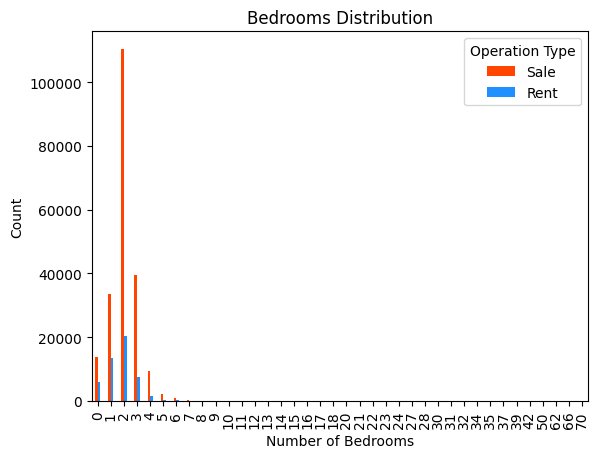

In [ ]:
# Sales/Rent bedrooms distribution
value_counts_buy = df_filled[df_filled['operation_type'] == 'Sale']['bedrooms'].value_counts()
value_counts_rent = df_filled[df_filled['operation_type'] == 'Rent']['bedrooms'].value_counts()

combined_value_counts = pd.concat([value_counts_buy, value_counts_rent], axis=1)
combined_value_counts.columns = ['Sale', 'Rent']
combined_value_counts.fillna(0, inplace=True)
combined_value_counts.sort_index(inplace=True)

ax = combined_value_counts.plot(kind='bar', width=0.4, color=['orangered', 'dodgerblue'])
ax.set_title('Bedrooms Distribution')
ax.set_xlabel('Number of Bedrooms')
ax.set_ylabel('Count')
ax.legend(title='Operation Type')
plt.show()

<u>Comments:</u>  
1) Both sales and rent distributions indicate a market preference for properties with fewer rooms, likely catering to individuals, couples, or smaller families.
This trend might be driven by economic factors, changing demographics, or urbanization in Argentina.

In [ ]:
contingency_table = pd.crosstab(df_filled['operation_type'], df_filled['bedrooms'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("Chi-Square Test Statistic:", chi2)
print("p-value:", p_value)

Chi-Square Test Statistic: 6017.285840214708
p-value: 0.0


The p-value is zero smaller than the significance level of 0.05 and thus we reject the null hypothesis of the chi-square test, suggesting that the probability of observing our data if
there's no association between 'operation_type' and 'bedrooms' is exceedingly low, reinforcing our belief in a meaningful connection between the two variables.

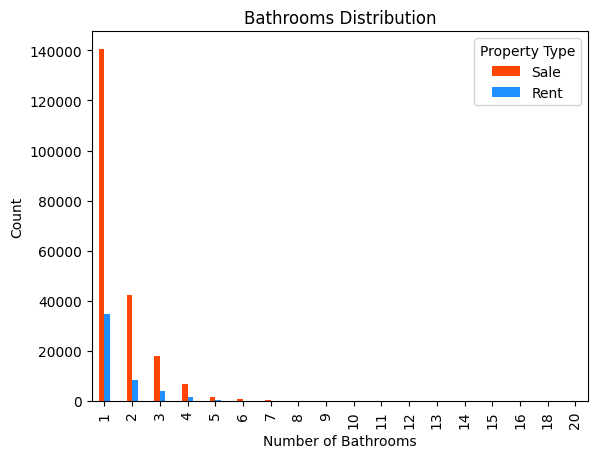

In [ ]:
# Sales/Rent bathrooms distribution
value_counts_buy = df_filled[df_filled['operation_type'] == 'Sale']['bathrooms'].value_counts()
value_counts_rent = df_filled[df_filled['operation_type'] == 'Rent']['bathrooms'].value_counts()
combined_value_counts = pd.concat([value_counts_buy, value_counts_rent], axis=1)
combined_value_counts.columns = ['Sale', 'Rent']
combined_value_counts.fillna(0, inplace=True)
combined_value_counts.sort_index(inplace=True)

ax = combined_value_counts.plot(kind='bar', width=0.4, color=['orangered', 'dodgerblue'])
ax.set_title('Bathrooms Distribution')
ax.set_xlabel('Number of Bathrooms')
ax.set_ylabel('Count')
ax.legend(title='Property Type')
plt.show()

<u>Comments:</u>  
1) Both distributions indicate a market preference for properties with fewer bathrooms. This aligns with the market’s preference for smaller properties, as seen in the previous plots on room distribution.
The preference might be influenced by affordability, space constraints, or demographic factors.

In [ ]:
contingency_table = pd.crosstab(df_filled['operation_type'], df_filled['bathrooms'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("Chi-Square Test Statistic:", chi2)
print("p-value:", p_value)

Chi-Square Test Statistic: 374.2130436820687
p-value: 4.48549023982015e-69


Again, p-value is extremely small, lower than the significance level of 0.05, thus we reject the null hypothesis of the chi-square test. This suggests that it's highly improbable to observe our data if there's no association between 'operation_type' and 'bathrooms'. Therefore, we conclude that there is indeed a significant connection between the two variables.








### **Operation_type and l2**

In [ ]:
contingency_table = pd.crosstab(df_filled['operation_type'], df_filled['l2'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("Chi-Square Test Statistic:", chi2)
print("p-value:", p_value)

Chi-Square Test Statistic: 5980.206805892936
p-value: 0.0


The p-value is zero which is less than our significance level of 0.05 and thus we reject the null hypothesis of the chi-square test, which means it's highly unlikely to see the data we observed if there's no connection between 'operation_type' and 'l2'. Thus, we believe there is a connection.

### **Operation_type and l3**



In [ ]:
contingency_table = pd.crosstab(df_filled['operation_type'], df_filled['l3'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("Chi-Square Test Statistic:", chi2)
print("p-value:", p_value)

Chi-Square Test Statistic: 16991.878880977987
p-value: 0.0


The p-value, which is 0 and lower than our significance level of 0.05, indicates that it's highly improbable to observe the data we have if there's no association between 'operation_type' and 'l3'. Consequently, we infer that there is indeed a connection between the two variables.

In [ ]:
df_filled[['l2', 'l3']]

,l2,l3
0,Bs.As. G.B.A. Zona Norte,Tigre
1,Santa Fe,Alvear
2,Santa Fe,Alvear
3,Santa Fe,Alvear
4,Buenos Aires Interior,Luján
...,...,...
259905,Santa Fe,Funes
259906,Santa Fe,Funes
259907,Santa Fe,Funes
259908,Santa Fe,Funes


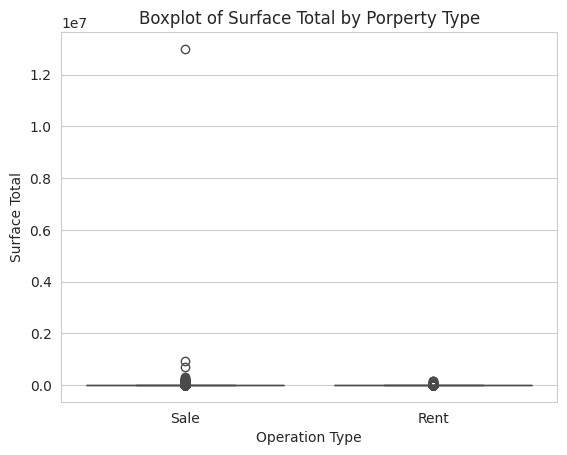

In [ ]:
#Boxplot of surface total and operation type
import seaborn as sns
sns.set_style("whitegrid")

sns.boxplot(x='operation_type', y='surface_total', hue='operation_type', data=df_filled, palette="Blues", legend=False)
plt.title('Boxplot of Surface Total by Porperty Type')
plt.xlabel('Operation Type')
plt.ylabel('Surface Total')
plt.show()

We can not observe much from these boxplots because they are very compact. The only thing we can observe is the outliers of these two boxplots and we will further explore them.

In [ ]:
Q1 = df_filled['surface_total'].quantile(0.25)
Q3 = df_filled['surface_total'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
cleaned_df_surfacetotal_filled = df_filled[(df_filled['surface_total'] >= lower_bound) & (df_filled['surface_total'] <= upper_bound)]

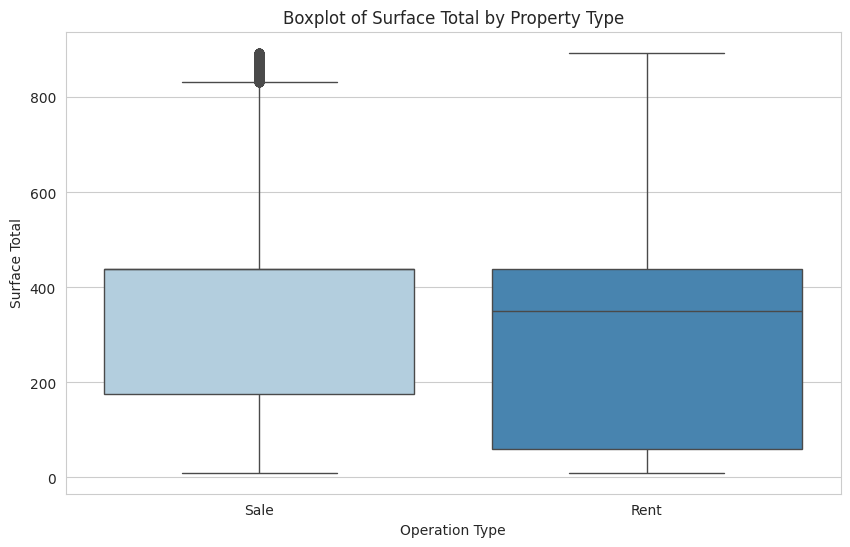

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.boxplot(x='operation_type', y='surface_total', data=cleaned_df_surfacetotal_filled, hue='operation_type', palette='Blues', legend=False)
plt.title('Boxplot of Surface Total cleaned from outliers by Property Type')
plt.xlabel('Operation Type')
plt.ylabel('Surface Total')
plt.show()

In [ ]:
median_surface_total = cleaned_df_surfacetotal_filled.groupby('operation_type')['surface_total'].median()
print(median_surface_total)

operation_type
Rent    350.00
Sale    438.17
Name: surface_total, dtype: float64


<u>Comments:</u>  
1) The median value for rental properties is  a bit higher than 350 square meters. This indicates that half of the rental properties have a total surface area smaller than this, while the other half have a larger surface area.  
2)  The range values of square meters for sale properties is quite similar to rent properties. This suggests that, on average, properties for sale tend to have similar surface areas with rental properties.  
3) Both boxplots exhibit a significant range, as seen by the lengths of the boxes and whiskers. The upper whisker extends well beyond the upper quartile in both cases, indicating that some properties have unusually large surface areas.

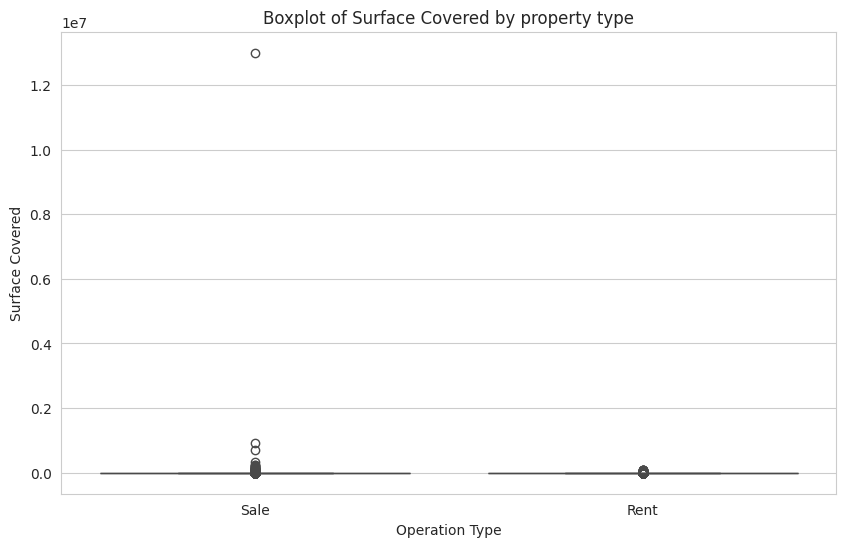

In [ ]:
# Operation_type VS Surface_covered
plt.figure(figsize=(10, 6))
sns.boxplot(x='operation_type', y='surface_covered', data=df_filled, hue='operation_type', palette='Blues', legend=False)
plt.title('Boxplot of Surface Covered by property type')
plt.xlabel('Operation Type')
plt.ylabel('Surface Covered')
plt.show()

* Both categories have low median values, suggesting that the majority of
properties have a smaller covered area.  
* There are several significant outliers for both sale and rent properties, as indicated by the data points above the whiskers.
These outliers suggest that some properties have unusually large covered areas compared to the general distribution.
The presence of these outliers indicates a wide variance in covered areas, highlighting that while most properties have a smaller covered area, a few properties are much larger.

In [ ]:
Q1 = df_filled['surface_covered'].quantile(0.25)
Q3 = df_filled['surface_covered'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
cleaned_df_surfacovered_filled = df_filled[(df_filled['surface_covered'] >= lower_bound) & (df_filled['surface_covered'] <= upper_bound)]

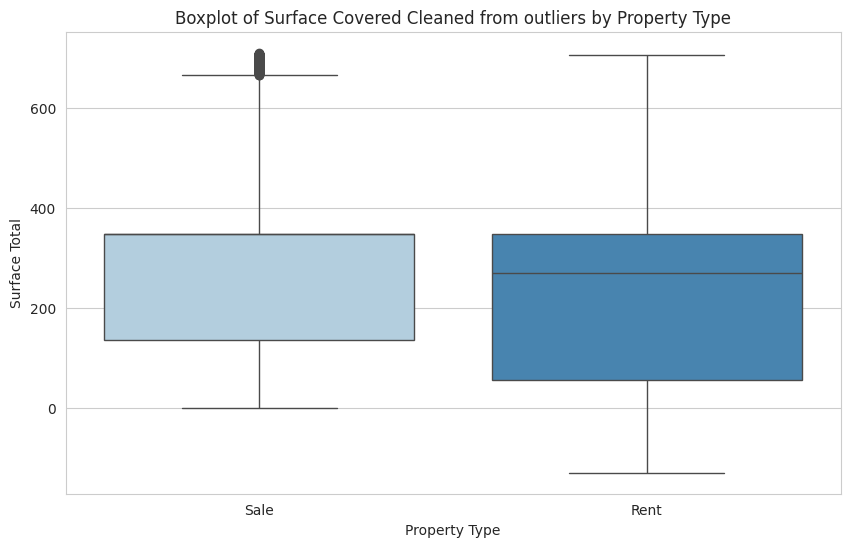

In [ ]:
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='operation_type', y='surface_covered', data=cleaned_df_surfacovered_filled, hue ='operation_type', palette='Blues')
plt.title('Boxplot of Surface Covered Cleaned from outliers by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Surface Total')
plt.show()

* Rent: The covered surface area ranges from  approximately 100 and 350 square meters, with a median above 200 square meters,close to 250, and a broader spread up to 350 square meters.

* Sale: Properties for sale typically have a surface area ranging from about less than 200 to less than 400 square meters.Smaller range instead of the Rent.

This cleaned-up visualization highlights that properties for sale often have a slightly larger typical covered area compared to rental properties, with a broader distribution of sizes.



<ipython-input-74-9080324d223e>:3: UserWarning: The palette list has more values (12) than needed (10), which may not be intended.
  ax = sns.countplot(x='operation_type', hue='property_type', data=df_filled, palette=palette)


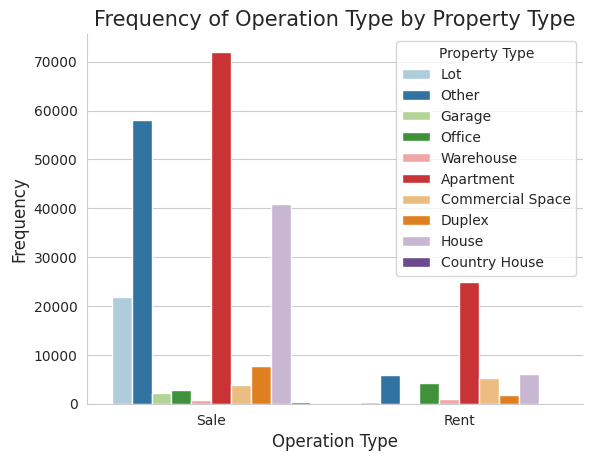

In [ ]:
sns.set_style("whitegrid")
palette = sns.color_palette("Paired")
ax = sns.countplot(x='operation_type', hue='property_type', data=df_filled, palette=palette)

plt.title('Frequency of Operation Type by Property Type', fontsize=15)
plt.xlabel('Operation Type', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Property Type', loc='upper right')
sns.despine()
plt.show()

<u>Comments:</u>  
* The chart reveals that "Apartment" and "House" are the most frequently listed property types, whether for sale or rent.
* Other property types such as "Garage," "Warehouse," and "Commercial Space" have lower frequencies, indicating they might represent niche markets.
* The distribution highlights that properties such as "Lot" and "Office" are more frequently listed for sale rather than rent, reflecting potential buyer preferences or market conditions.


In [ ]:
contingency_table = pd.crosstab(df_filled['operation_type'], df_filled['property_type'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("Chi-Square Test Statistic:", chi2)
print("p-value:", p_value)

Chi-Square Test Statistic: 30658.063187459862
p-value: 0.0


Both the barplot and the Chi-Square Test say that the property type and the opearation type are not independent to each other. There is a assocation between of them.





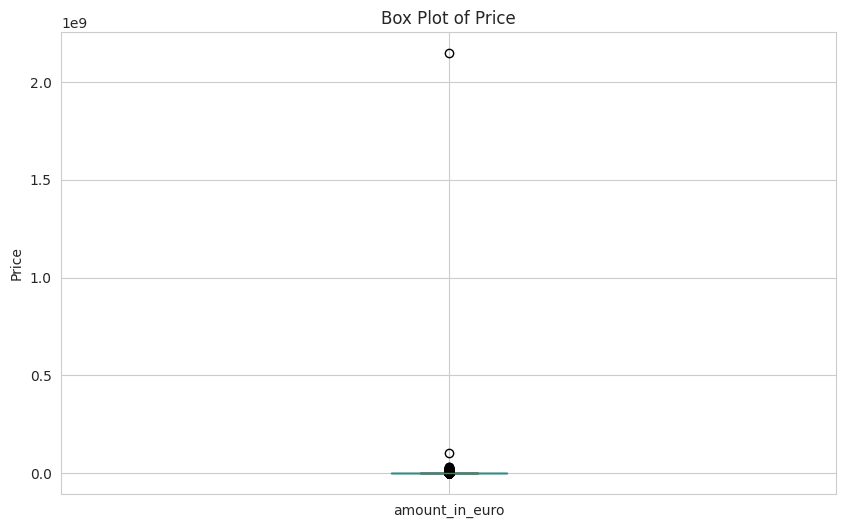

In [ ]:
plt.figure(figsize=(10, 6))
df_filled.boxplot(column='amount_in_euro')
plt.title('Box Plot of Price')
plt.ylabel('Price')
plt.show()

The box plot shows the distribution of property prices in euros. The median price, represented by the thick line within the box, is close to zero, indicating that most properties have relatively low prices. The interquartile range (IQR), which spans from the 25th to the 75th percentile, is narrow and centered close to zero, suggesting that the majority of properties fall within a tight price range at the lower end of the scale. However, the plot also reveals several outliers, with one notable outlier exceeding 2 billion euros. This significant outlier is likely an exceptional case, such as a luxury property or a commercial space. The presence of such high-value outliers highlights the need to consider these separately when analyzing typical property prices to avoid skewing the overall market analysis.

In [ ]:
Q1 = df_filled['amount_in_euro'].quantile(0.25)
Q3 = df_filled['amount_in_euro'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df_filled[(df_filled['amount_in_euro'] >= lower_bound) & (df_filled['amount_in_euro'] <= upper_bound)]

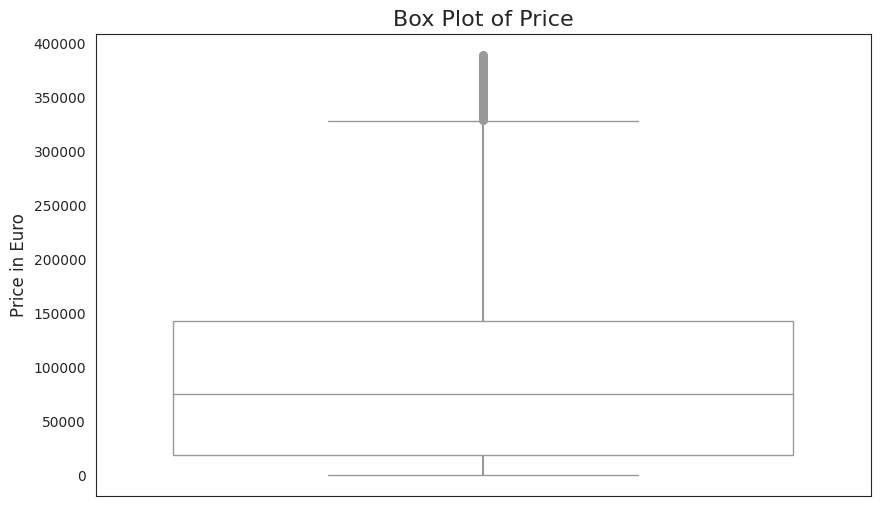

In [ ]:
sns.set_style("white")
plt.figure(figsize=(10, 6))
ax = sns.boxplot(y=df_filtered['amount_in_euro'], color="white", fliersize=5, whiskerprops={'linewidth': 1.5})
plt.title('Box Plot of Price', fontsize=16)
plt.ylabel('Price in Euro', fontsize=12)
plt.xlabel('')
plt.show()

This boxplot visualizes the distribution of property prices in euros without the outliers, as indicated by the vertical axis. The box represents the interquartile range (IQR), which contains the middle 50% of the data, while the horizontal line within the box indicates the median price. The whiskers extending from the box show the range of the data, excluding outliers, which are absent in this case. The median is centered around 100,000 euros, suggesting that this value represents the typical property price in the dataset. The plot effectively uses a clear and straightforward layout, enhancing readability and focusing on the key statistical indicators.

<ipython-input-81-343629a21183>:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(x='operation_type', y='amount_in_euro', data=df_filled, hue='operation_type', palette=palette, legend=False)


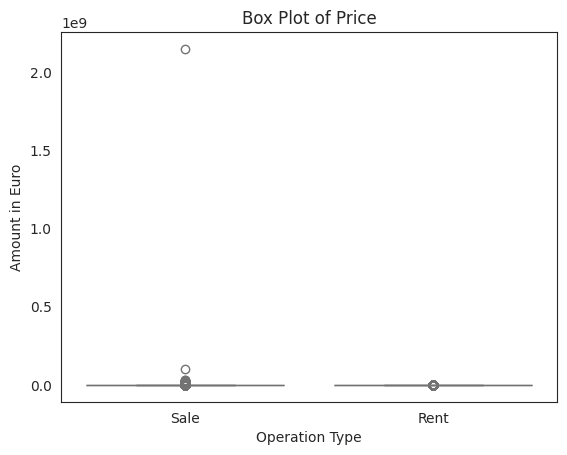

In [ ]:
palette = sns.color_palette("pastel")
sns.boxplot(x='operation_type', y='amount_in_euro', data=df_filled, hue='operation_type', palette=palette, legend=False)
plt.title('Box Plot of Price')
plt.xlabel('Operation Type')
plt.ylabel('Amount in Euro')
plt.show()

This boxplot represents the distribution of property prices for both sales and
rental operations, as indicated by the x-axis labels. The vertical axis displays the amount in euros, which is on a logarithmic scale, evidenced by the notation 1e9 on the upper end. This suggests that there are significant outliers, as seen by the large spread of the data.

The boxplots for both sales and rental properties show that the majority of the data points are concentrated close to zero, indicating that the bulk of properties have lower prices. However, a few outliers in both categories extend dramatically, with some reaching into the billion-euro range. These extreme outliers might indicate either exceptionally valuable properties or data entry errors.

The median price, represented by the line inside each box, is low for both categories, aligning with the overall distribution's concentration near zero. The plot highlights the stark difference between typical properties and exceptional cases, which can be critical information for stakeholders analyzing property markets.

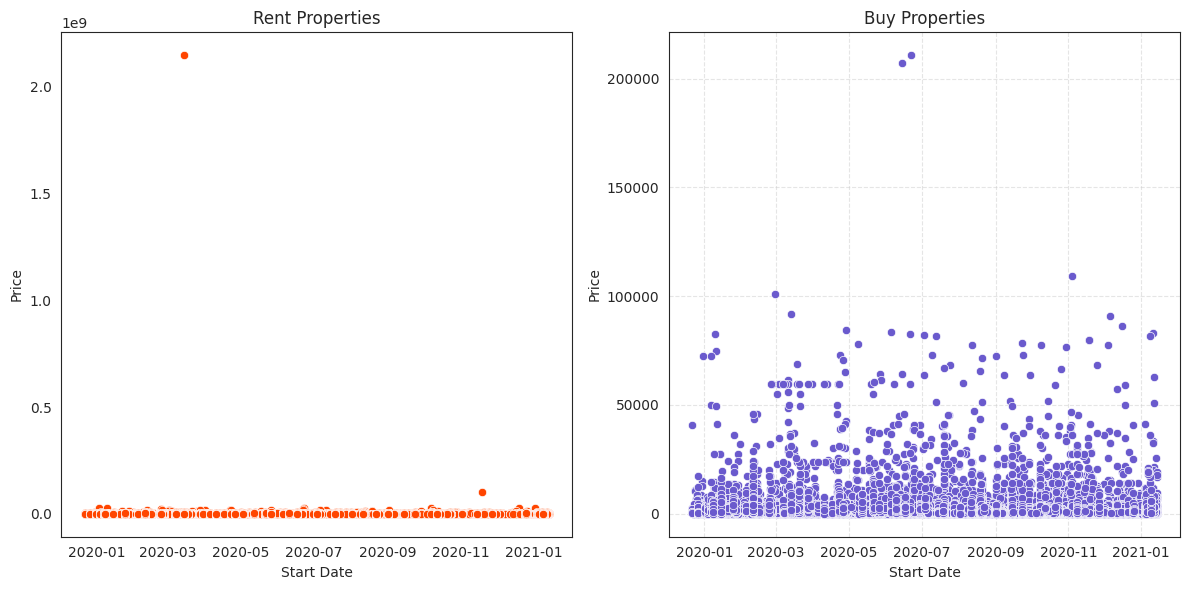

In [ ]:
# scatterplot for the price of each property
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

rent_data = df_filled[df_filled['operation_type'] == 'Sale']
buy_data = df_filled[df_filled['operation_type'] == 'Rent']

sns.scatterplot(x='start_date', y='amount_in_euro', data=rent_data, ax=axs[0], color='orangered')
axs[0].set_title('Rent Properties')
axs[0].set_xlabel('Start Date')
axs[0].set_ylabel('Price')

sns.scatterplot(x='start_date', y='amount_in_euro', data=buy_data, ax=axs[1], color='slateblue')
axs[1].set_title('Buy Properties')
axs[1].set_xlabel('Start Date')
axs[1].set_ylabel('Price')

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

<u>**Left Plot (Rent Properties):**</u>  
1) <u>Outliers:</u>The plot has an extreme outlier above 2 billion euros, indicating an unusually high-priced rental property.
Most of the other rental properties cluster close to zero, suggesting that such an extreme price is an anomaly.  
2) <u>Pattern:</u>The majority of rental properties are priced much lower, with minimal variation, as seen by the tightly packed cluster near the bottom.  

<u>**Right Plot (Buy Properties):**</u>  
1) <u>Distribution:</u>The plot shows a wider spread of prices compared to the rental properties, although the majority of properties are still under 100,000 euros.
There are a few notable outliers, with some prices exceeding 200,000 euros.  
2) <u>Pattern:</u> The buy properties demonstrate more variability in price, which could be due to differing property sizes, locations, and features.

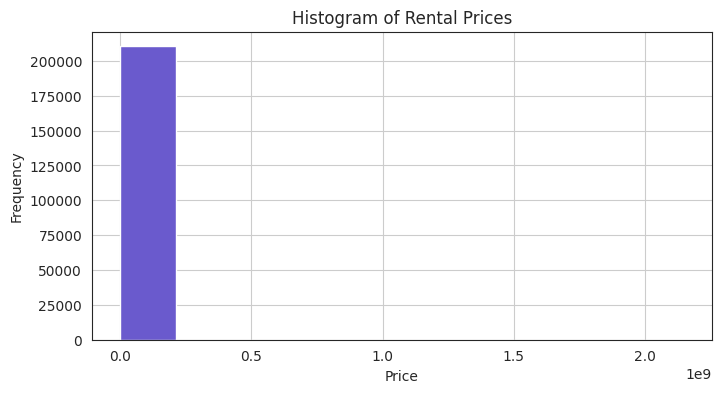

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(rent_data['amount_in_euro'], bins=10, color='slateblue')
plt.title('Histogram of Rental Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

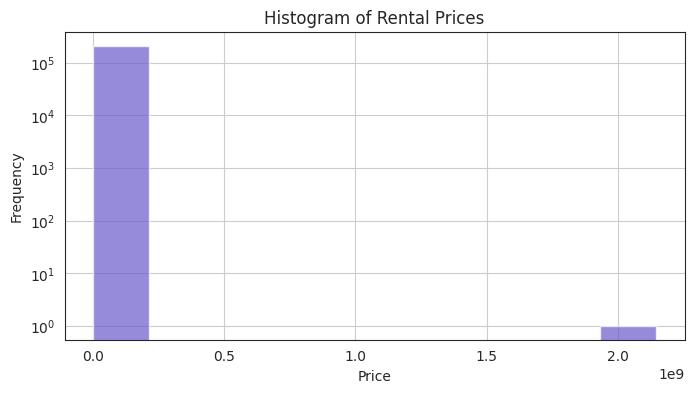

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(rent_data['amount_in_euro'], bins=10, color='slateblue', alpha=0.7, log = True)
plt.title('Histogram of Rental Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

 Two histograms of rental prices are provided, one plotted on a linear scale and the other on a logarithmic scale. Both show that the majority of rental prices are concentrated in the lower range, with a significant frequency at prices below €50,000. The logarithmic scale highlights how frequencies diminish rapidly as prices increase, providing a clear view of the skewness toward lower prices.

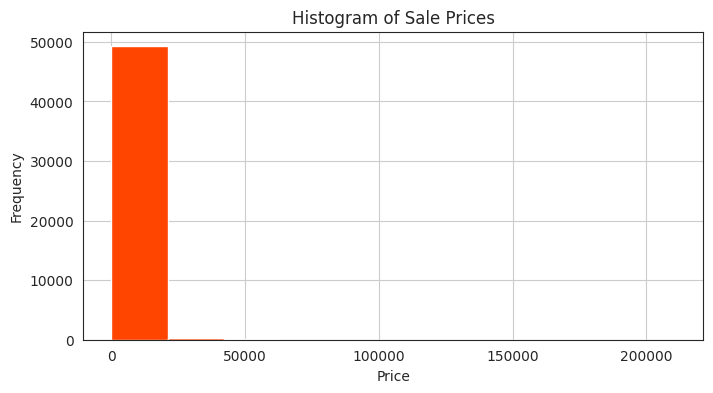

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(buy_data['amount_in_euro'], bins=10, color='orangered')
plt.title('Histogram of Sale Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

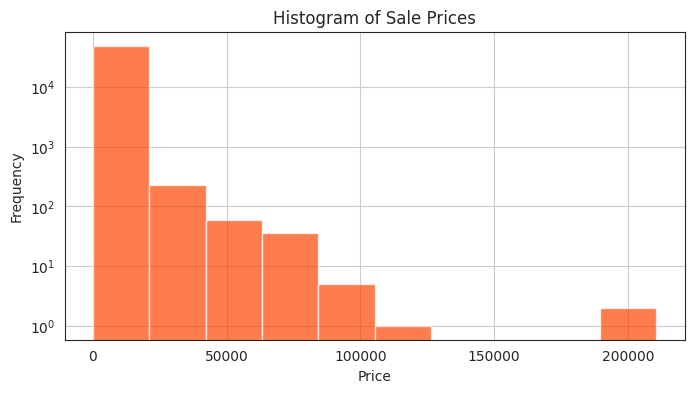

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(buy_data['amount_in_euro'], bins=10, color='orangered', alpha=0.7, log = True)
plt.title('Histogram of Sale Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

 Similarly, for buy prices, histograms on linear and logarithmic scales show that most purchase prices are clustered at the lower end of the spectrum. However, there's a broader distribution compared to rentals, extending up to €200000. The logarithmic scale better illustrates the distribution across different price ranges, showing a tail of higher-priced properties.

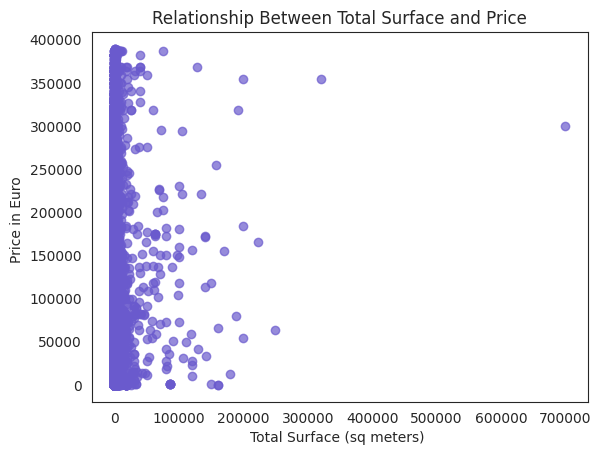

In [ ]:
plt.scatter(df_filtered['surface_total'], df_filtered['amount_in_euro'], alpha = 0.7, color = 'slateblue')
plt.title('Relationship Between Total Surface and Price')
plt.xlabel('Total Surface (sq meters) ')
plt.ylabel('Price in Euro ')
plt.show()

The scatter plot, depicting the relationship between total surface area (in square meters) and price (in euros), shows that most properties, especially those with smaller surface areas, are priced below €200,000. There are a few properties with large surface areas priced significantly higher, suggesting outliers or special cases where larger properties command premium prices. The concentration of points at the lower end of the surface and price scales indicates a high density of smaller, more affordable properties.

<ipython-input-88-ad15a9a903f4>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=df_filtered['amount_in_euro'], bins=20, color='orangered')


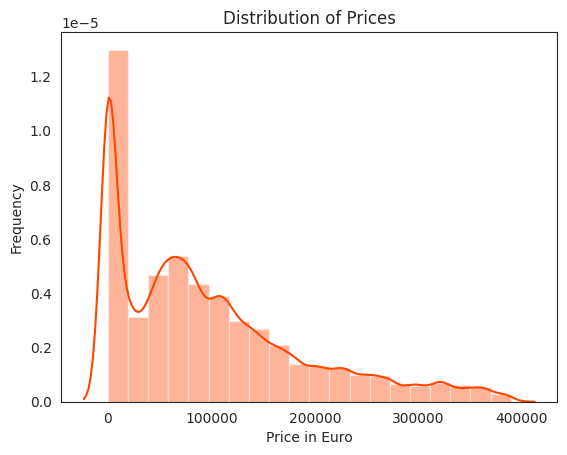

In [ ]:
sns.distplot(a=df_filtered['amount_in_euro'], bins=20, color='orangered')
plt.title('Distribution of Prices')
plt.xlabel('Price in Euro')
plt.ylabel('Frequency')
plt.show()

The plot is a histogram that shows a very sharp peak at lower prices with a long tail extending toward higher values. This indicates that most of the properties in our dataset are priced relatively low, with a few properties having much higher prices

<ipython-input-90-55c349d8af87>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='property_type', y='amount_in_euro', data=df_filtered, palette='Blues')


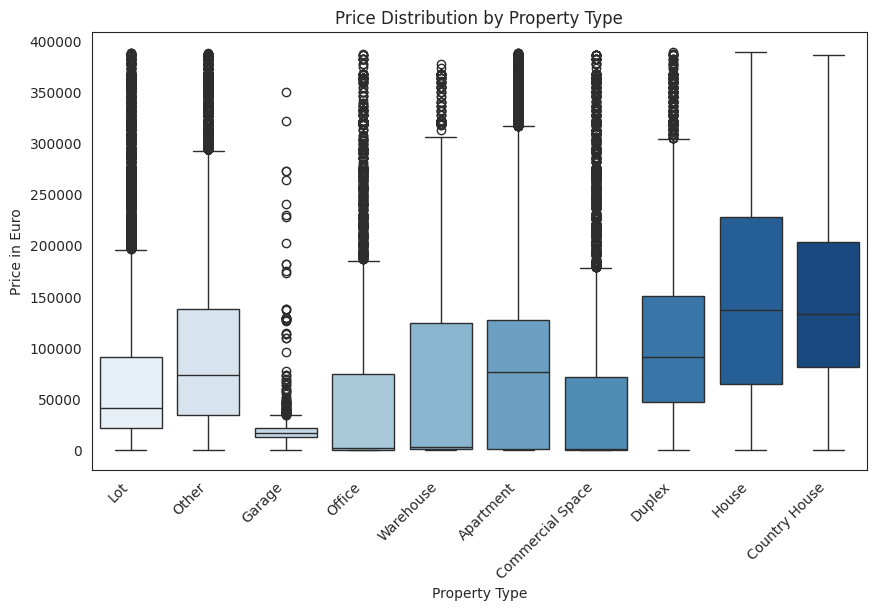

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='property_type', y='amount_in_euro', data=df_filtered, palette='Blues')
plt.title('Price Distribution by Property Type')
plt.xlabel('Property Type')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Price in Euro')
plt.subplots_adjust(bottom=0.15)
plt.show()

1) Lot:The median price is around 40,000 euros, with a wide interquartile range, indicating significant variability.
The plot contains numerous outliers, showing that while most lots have moderate prices, some are exceptionally high-priced.  
2) Other: The median price is higher than the one of "Lot," and the distribution is wider, suggesting more variability.
The plot shows many outliers as well.
3) Garage: The median price is around 25,000 euros, much lower than most other property types. The narrow interquartile range and fewer outliers indicate more consistent pricing for garages.  
4)Office: The median price is less than 10,000 euros, with a broad interquartile range, indicating substantial variability. There are numerous outliers, suggesting that some offices have very high prices.  
5) Warehouse: The median price is similar to that of "Office," but with a wider distribution. The plot contains many outliers, though they are more evenly spread out compared to some other property types.  
6) Apartment: The median price is more than 50,000 euros, similar to "Others" categorie. There are many outliers, indicating that some apartments are significantly more expensive.  
7) Commercial Space: The median price is lower, maybe lower than 10,000 euros as well, with a interquartile range similar to 'Office'. However,here are numerous outliers, suggesting that some Commercial Space have very high prices.   
8) Duplex: The median price is around 75,000 euros, with a wide interquartile range, indicating variability. The plot shows many outliers, suggesting that while most duplexes have moderate prices, some are significantly more expensive.  
9) House: The median price is around 100,000 euros, with a wide distribution and significant variability. The plot doesnt shows any outlier, demonstrating a uniform distribution of house prices. Although the range of prices varies from relatively low to quite high, the values are consistently spread across this spectrum, suggesting that both the minimum and maximum prices, while distinctly different, are typical for this dataset.
10) Country House: The median price is similar to that of "House" but with a slightly narrower interquartile range. The plot does not contains any outliers, indicating that all counrty house prices are distributed within a predictable range.

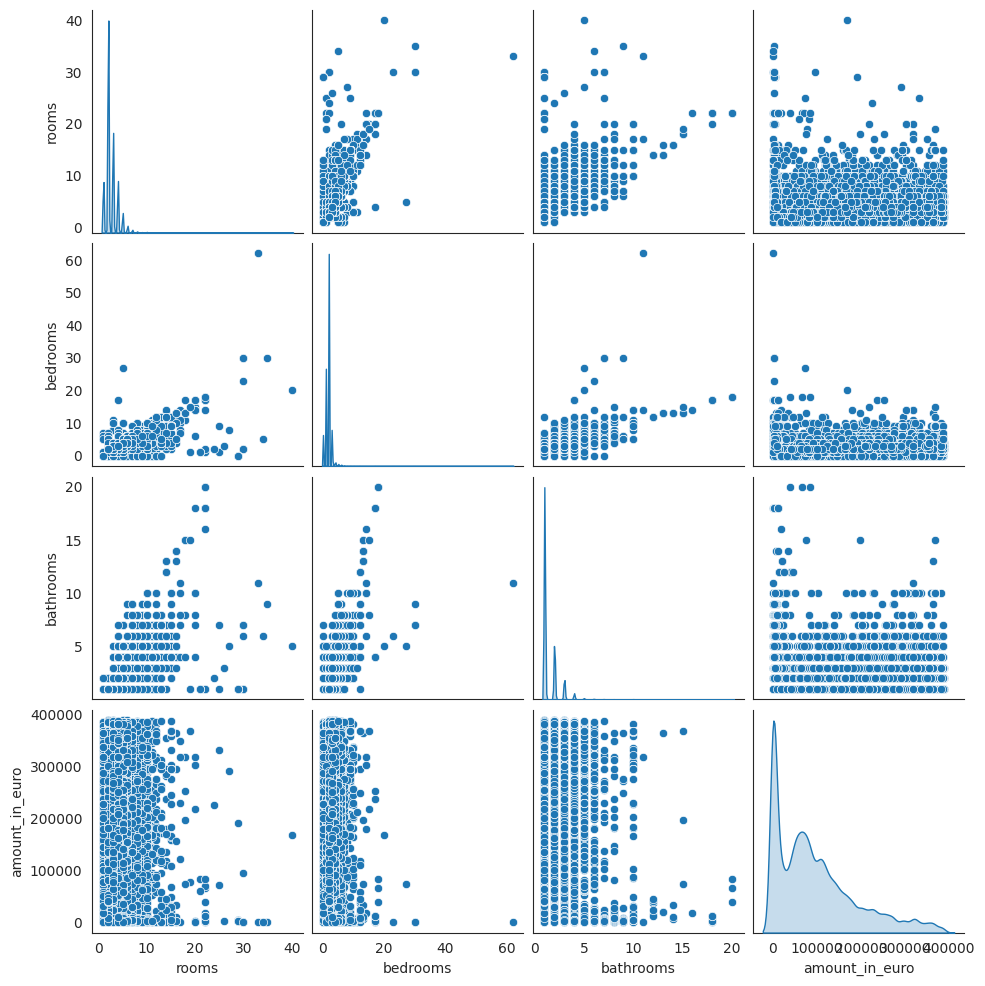

In [ ]:
sns.pairplot(df_filtered[['rooms', 'bedrooms', 'bathrooms', 'amount_in_euro']], diag_kind='kde')
plt.show()

The plots above, presented as a matrix of scatter plots, allows for the examination of relationships between different attributes such as the number of rooms, bedrooms, bathrooms, and their corresponding prices.  
It’s evident that while there is a tendency for properties with more rooms or bathrooms to have higher prices, the correlation is not strongly linear, implying other factors may influence the final property prices significantly.  
The histograms along the diagonal of the matrix help visualize the distribution of each attribute separately, showing, for example, that most properties have fewer than 10 rooms and the price distribution has a long tail, as seen in the standalone histogram.

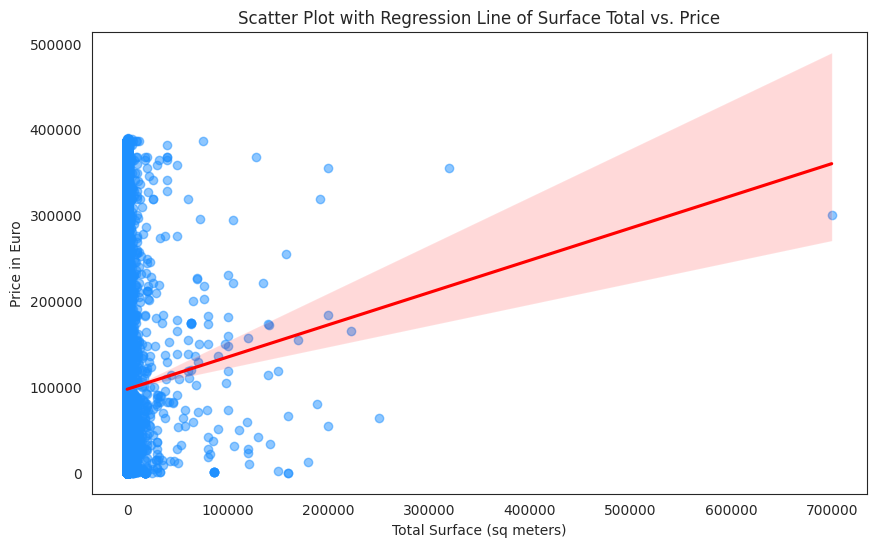

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(x='surface_total', y='amount_in_euro', data=df_filtered, scatter_kws={'alpha':0.5}, line_kws={'color':'red'}, color = 'dodgerblue')
plt.title('Scatter Plot with Regression Line of Surface Total vs. Price')
plt.xlabel('Total Surface (sq meters)')
plt.ylabel('Price in Euro')
plt.show()

This plot shows the relationship between the total surface area of properties and their *prices*. A regression line is drawn to indicate the general trend. The positive slope of the regression line suggests that as the surface area increases, the price tends to increase as well. The shaded area around the regression line represents the confidence interval, indicating where future data points are expected to fall with a certain probability. The plot highlights a strong concentration of data points at the lower end of the surface area, with prices clustered below €100,000, although there are some outliers with large surface areas commanding higher prices.

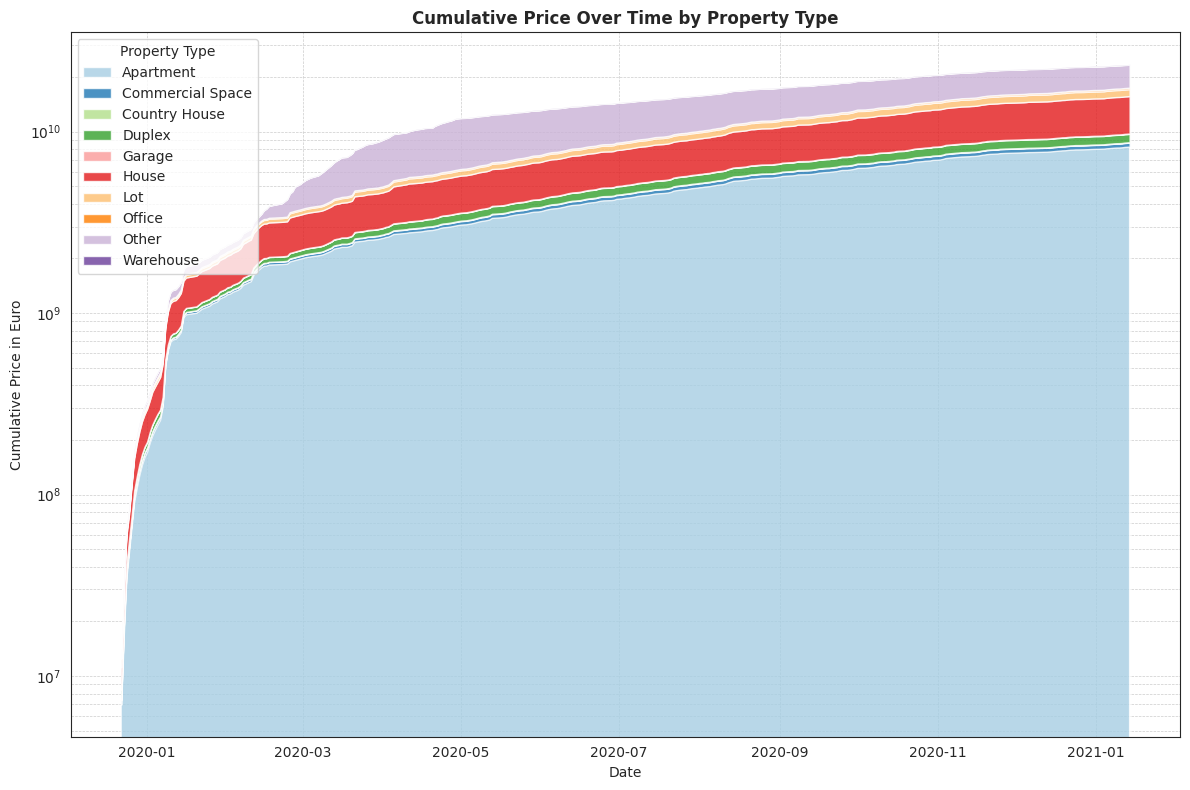

In [ ]:
# Cumulative Price Over Time by Property Type

df_filtered.loc[:, 'start_date'] = pd.to_datetime(df_filtered['start_date'])
pivot_data = df_filtered.pivot_table(index='start_date', columns='property_type', values='amount_in_euro', aggfunc='sum', fill_value=0)
palette = sns.color_palette("Paired", n_colors=len(pivot_data.columns))
cumulative_data = pivot_data.cumsum()
plt.figure(figsize=(12, 8))
plt.stackplot(cumulative_data.index, cumulative_data.T, labels=cumulative_data.columns, colors=palette, alpha=0.8)
plt.title('Cumulative Price Over Time by Property Type', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Cumulative Price in Euro')
plt.yscale('log')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend(loc='upper left', title='Property Type')
plt.tight_layout()
plt.show()

This area chart tracks the cumulative price over time, segmented by different property types. It provides insight into which property types dominate the market value over a specified period. For example, properties labeled as 'Casa' (houses) and 'Casa de campo' (country houses) show a significant accumulation of value over time, which suggests a higher total investment in these types compared to others like 'Cochera' (garages) or 'Oficina' (offices). The use of a logarithmic scale on the y-axis helps in viewing properties with vastly different price scales more comparably.

<ipython-input-95-b9de12e7ef88>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['start_date'] = pd.to_datetime(df_filtered['start_date'])


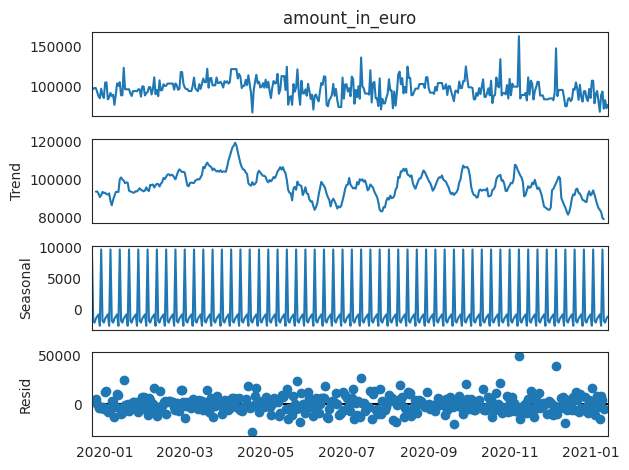

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
df_filtered['start_date'] = pd.to_datetime(df_filtered['start_date'])
df_time_series = df_filtered.set_index('start_date')
df_daily = df_time_series['amount_in_euro'].resample('D').mean().fillna(method='ffill')
result = seasonal_decompose(df_daily, model='additive')
result.plot()
plt.show()

Also that plot decomposes a time series of prices into three components: trend, seasonality, and residuals. The 'amount_in_euro' panel shows the raw data, indicating fluctuations over time. The 'Trend' panel smooths these fluctuations to highlight longer-term movements in price. 'Seasonal' illustrates repeating short-term patterns within the data, and 'Resid' shows the residuals, or deviations from the model, highlighting anomalies or unexpected variations. This decomposition is useful for understanding underlying patterns and anomalies in pricing data, which can be critical for forecasting and strategic planning.

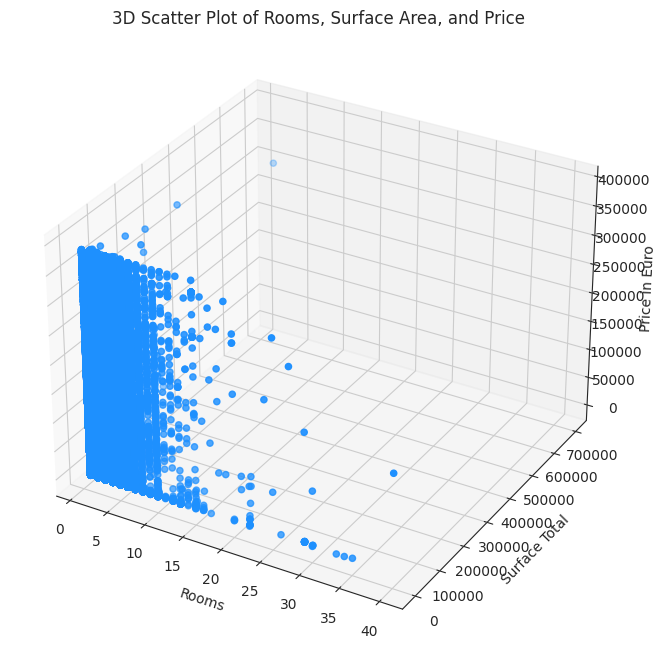

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_filtered['rooms'], df_filtered['surface_total'], df_filtered['amount_in_euro'], color = 'dodgerblue')
ax.set_xlabel('Rooms')
ax.set_ylabel('Surface Total')
ax.set_zlabel('Price in Euro')
plt.title('3D Scatter Plot of Rooms, Surface Area, and Price')
plt.show()

The majority of the data points are concentrated towards the lower end of all three dimensions—suggesting that smaller properties with fewer rooms generally fall into lower price brackets.  
As the number of rooms or the surface area increases, there are some increases in price as well, but this trend does not appear to be strictly linear.   
The plot shows some outliers, particularly in terms of surface area and price. A few properties with large surface areas or a high number of rooms command significantly higher prices, though these are exceptions rather than the rule.

In [ ]:
df_filtered.to_csv(google_drive_path + 'df_EDA.csv', index = False, sep = ',')  # saving the 0.3% new dataset